In [1]:
%load_ext autoreload
%autoreload 2
import optax, jax, numpy as np, os, pickle
from flax import nnx
from jax import numpy as jnp
from vistool import pca_plot
from sklearn.decomposition import IncrementalPCA
from fedflax import train
from tqdm.auto import tqdm
from data import create_digits
from models import ResNet
n = 4 # number of clients

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train

In [ ]:
# Optimizer
opt = lambda model: nnx.Optimizer(
    model,
    optax.adamw(learning_rate=1e-3),
    wrt=nnx.Param
)

# # Sharpness-aware minimization optimizer
# opt = lambda model: nnx.Optimizer(
#     model,
#     optax.contrib.sam(
#         optax.adamw(learning_rate=1e-3),
#         optax.chain(optax.contrib.normalize(), optax.adam(1e-2)),
#         sync_period=5
#     ),
#     wrt=nnx.Param
# )

# Loss includes softmax layer
def return_ell(omega):
    def ell(model, model_g, x_batch, y_batch):
        prox = sum(jax.tree.map(lambda a, b: jnp.sum((a-b)**2), jax.tree.leaves(model), jax.tree.leaves(model_g)))
        ce = optax.softmax_cross_entropy(model(x_batch), y_batch).mean()
        return omega/2*prox + ce, (prox, ce)
    return ell

# For all beta-e-omega setting
for beta in [.95,0.7,.45]:
    # Create data
    x_train, y_train, x_val, y_val, *_ = create_digits(beta)
    for local_epochs in [4,20,80]:
        for omega in [0.,.025,.1]:
            # Optimize
            train(ResNet, opt, x_train, y_train, x_val, y_val, return_ell(omega), local_epochs, f"large_digits/params_beta{beta}_omega{omega}_local{local_epochs}.npy")

round 0, -- patience 0, val loss 0.37776392698287964 -- global validation accuracy: 0.8763021230697632
round 1, -- patience 0, val loss 0.17065569758415222 -- global validation accuracy: 0.9466146230697632
round 2, -- patience 0, val loss 0.18035583198070526 -- global validation accuracy: 0.953125
round 3, -- patience 1, val loss 0.18166539072990417 -- global validation accuracy: 0.9583333730697632
round 4, -- patience 2, val loss 0.19696693122386932 -- global validation accuracy: 0.94921875
round 5, -- patience 3, val loss 0.18379870057106018 -- global validation accuracy: 0.951171875
round 6, -- patience 4, val loss 0.2027416229248047 -- global validation accuracy: 0.9498698115348816
round 0, -- patience 0, val loss 0.24128124117851257 -- global validation accuracy: 0.9303385615348816
round 1, -- patience 0, val loss 0.20075462758541107 -- global validation accuracy: 0.9342448115348816
round 2, -- patience 0, val loss 0.19373366236686707 -- global validation accuracy: 0.9342448115348

## Visualizations

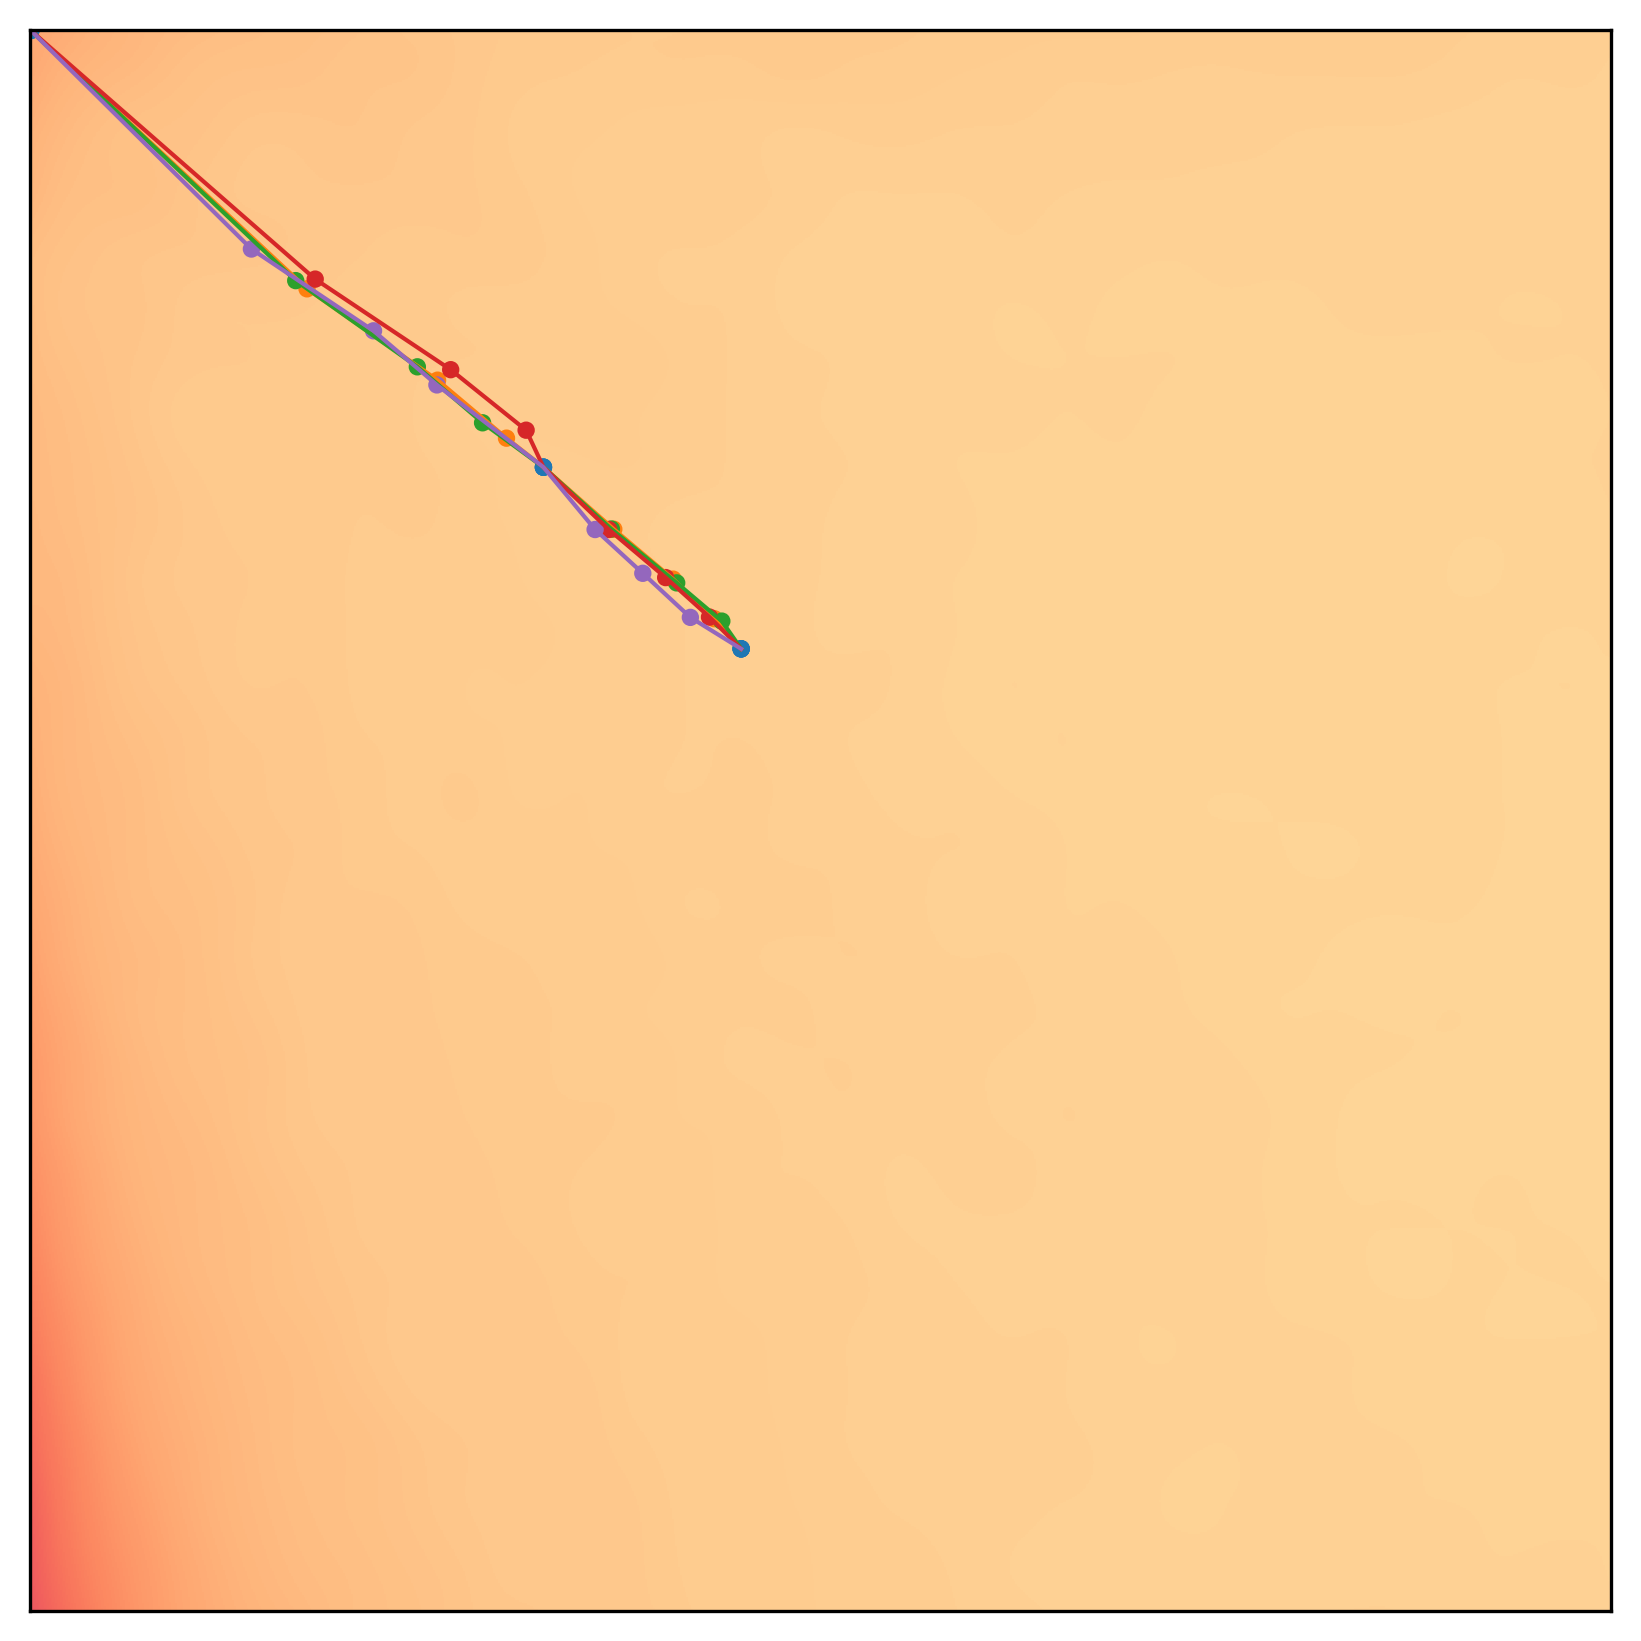

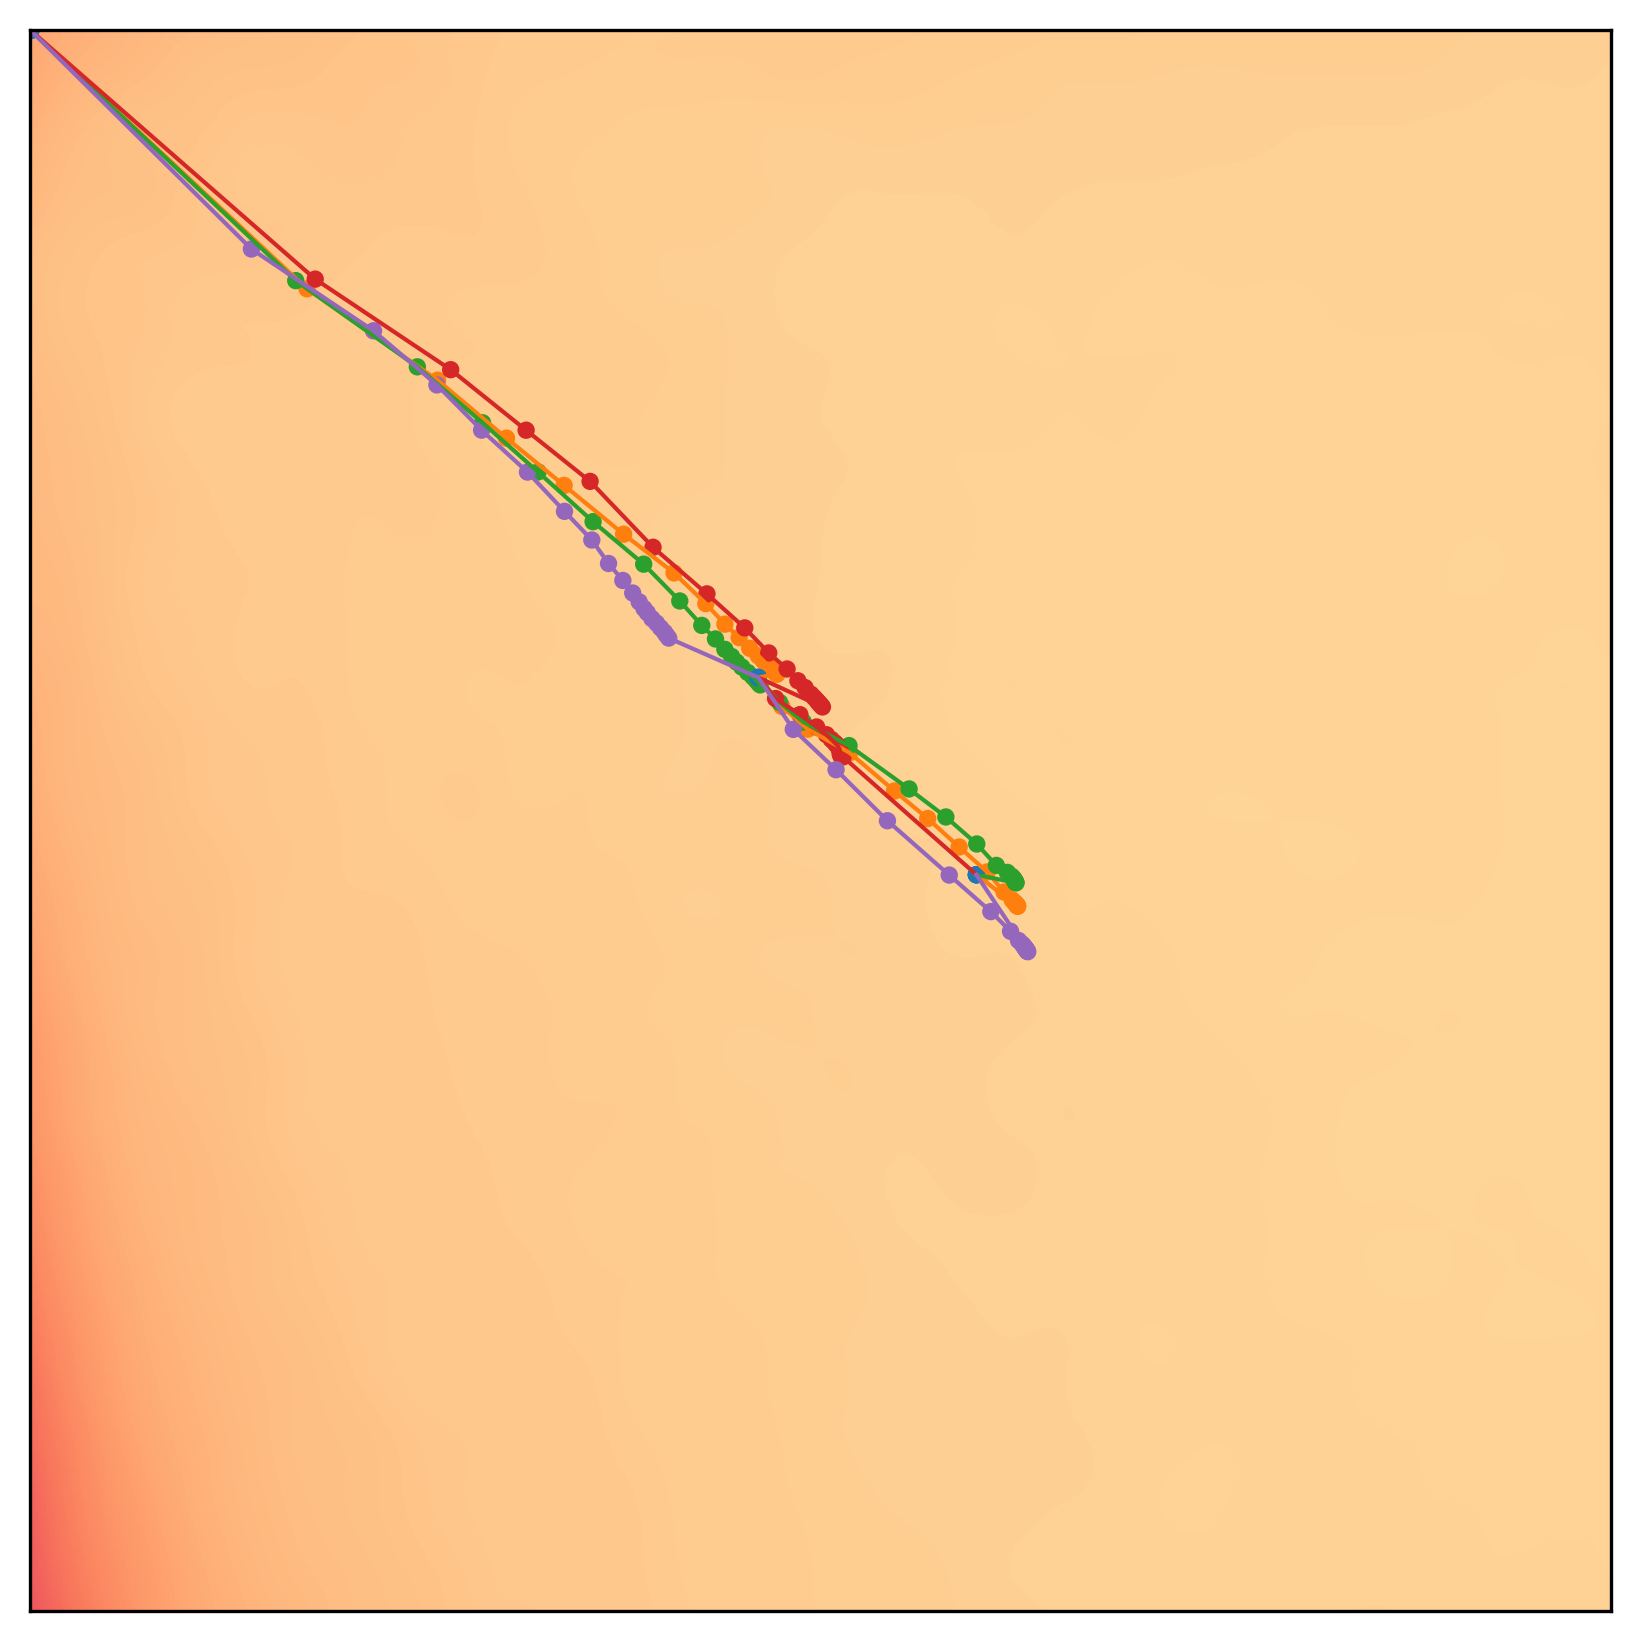

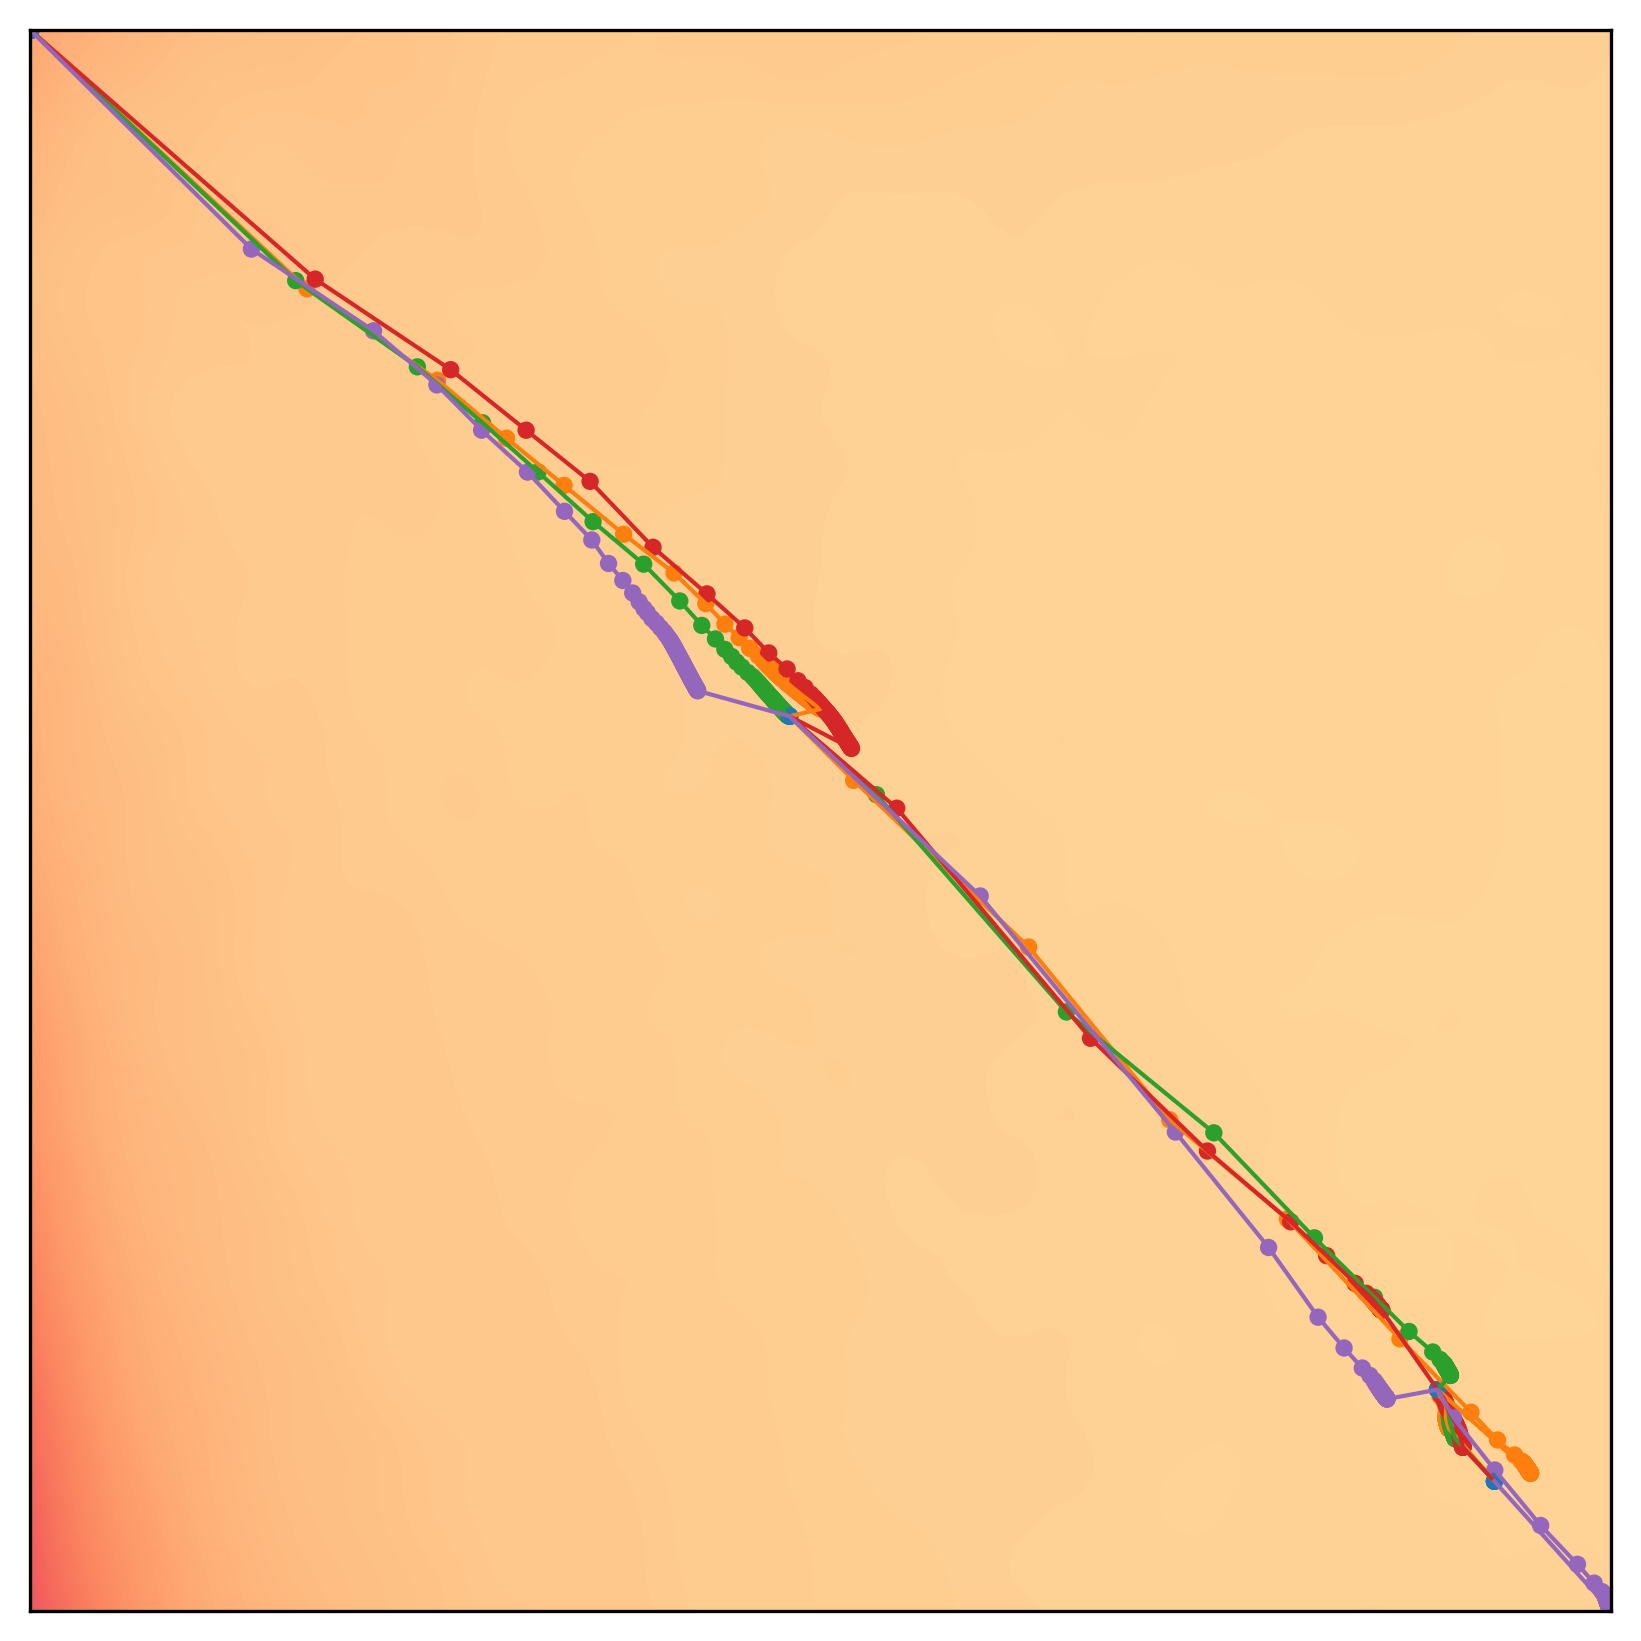

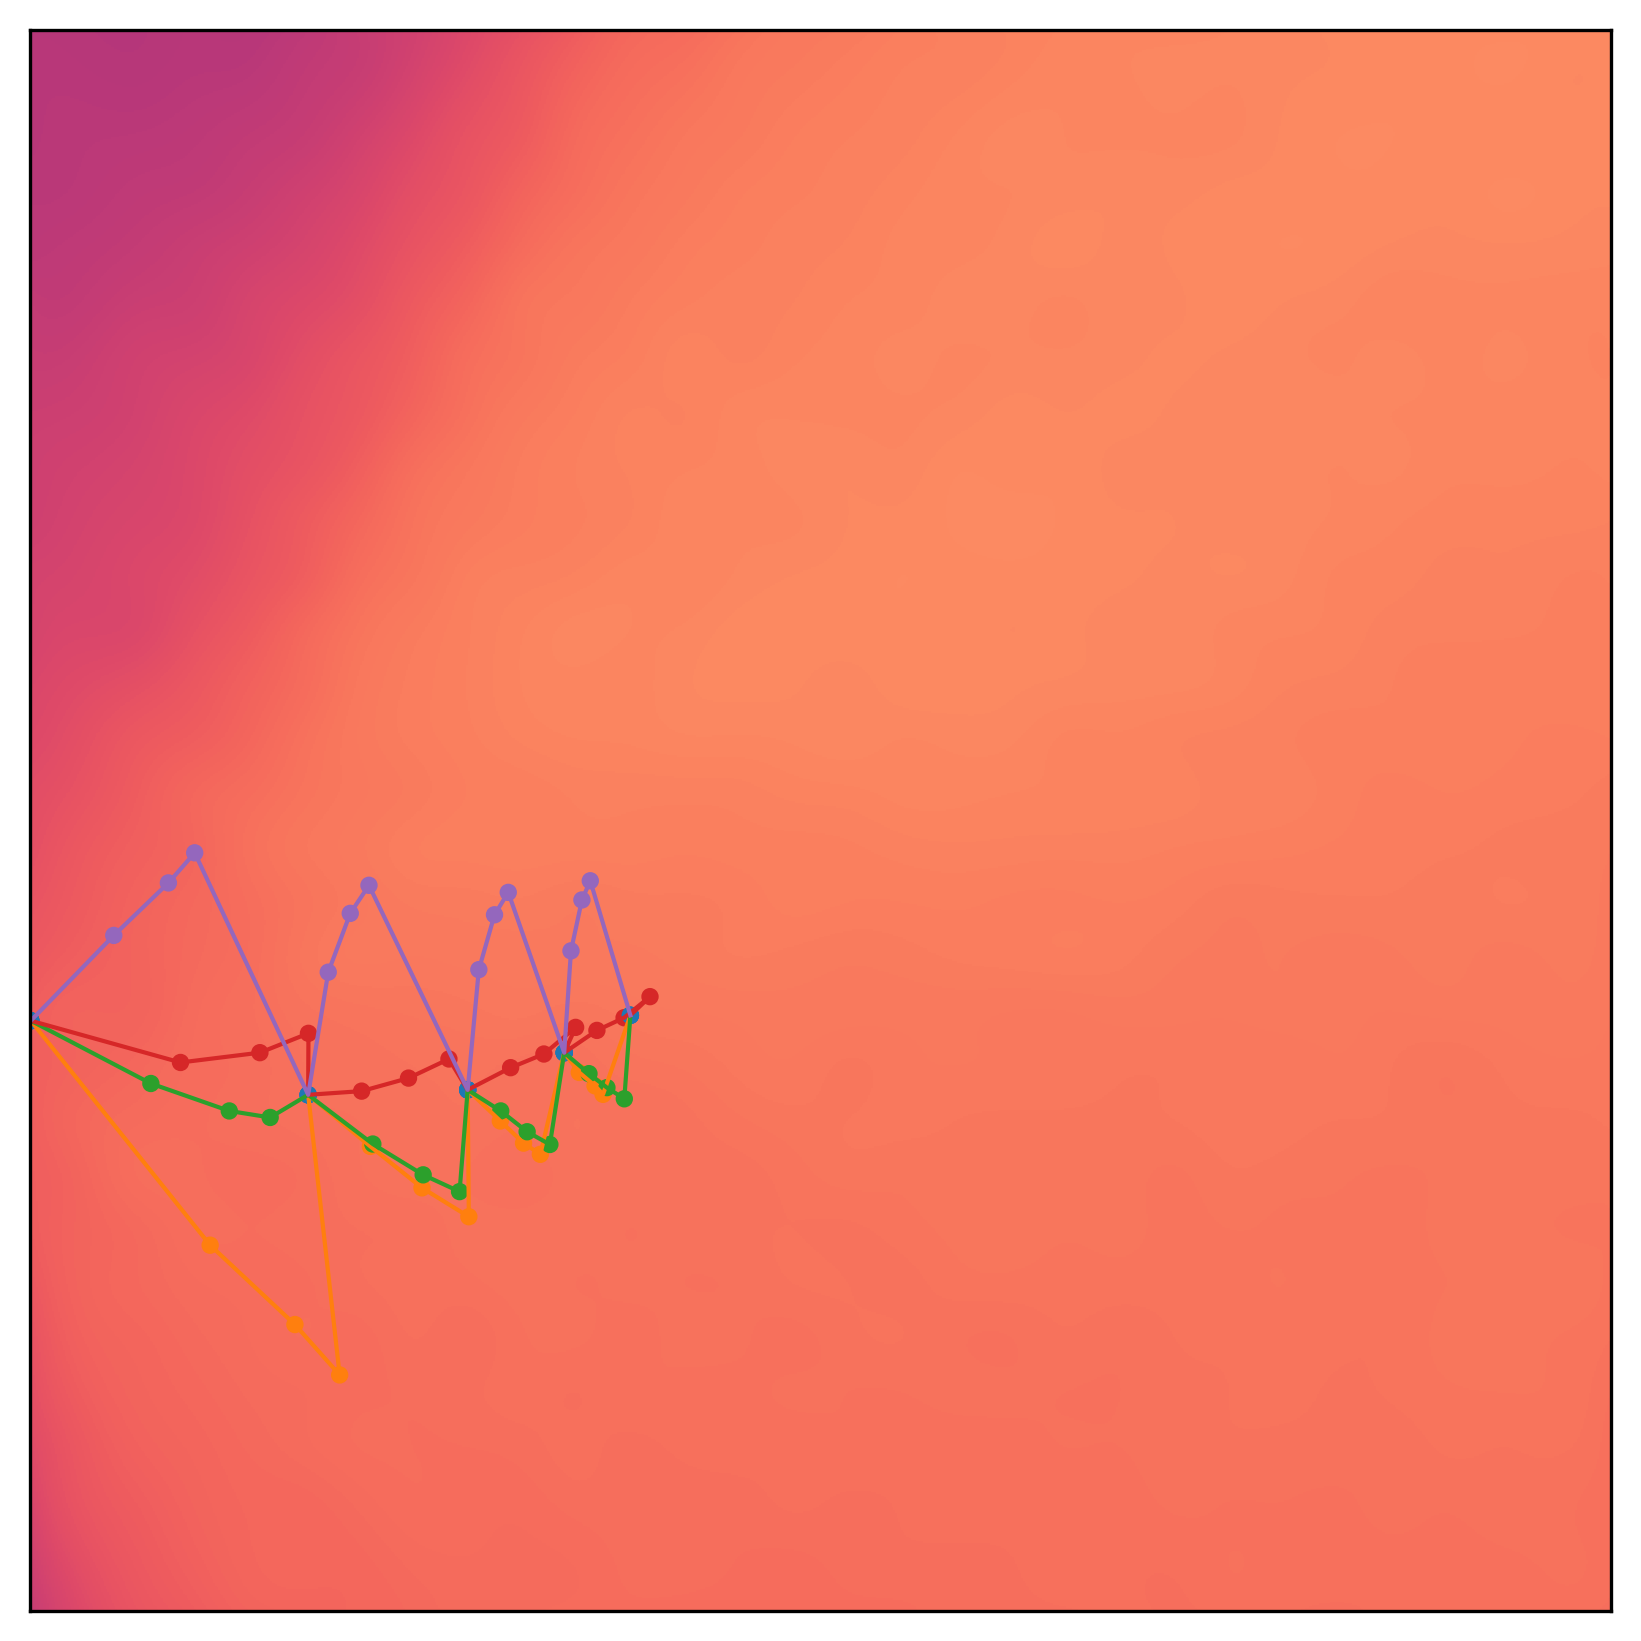

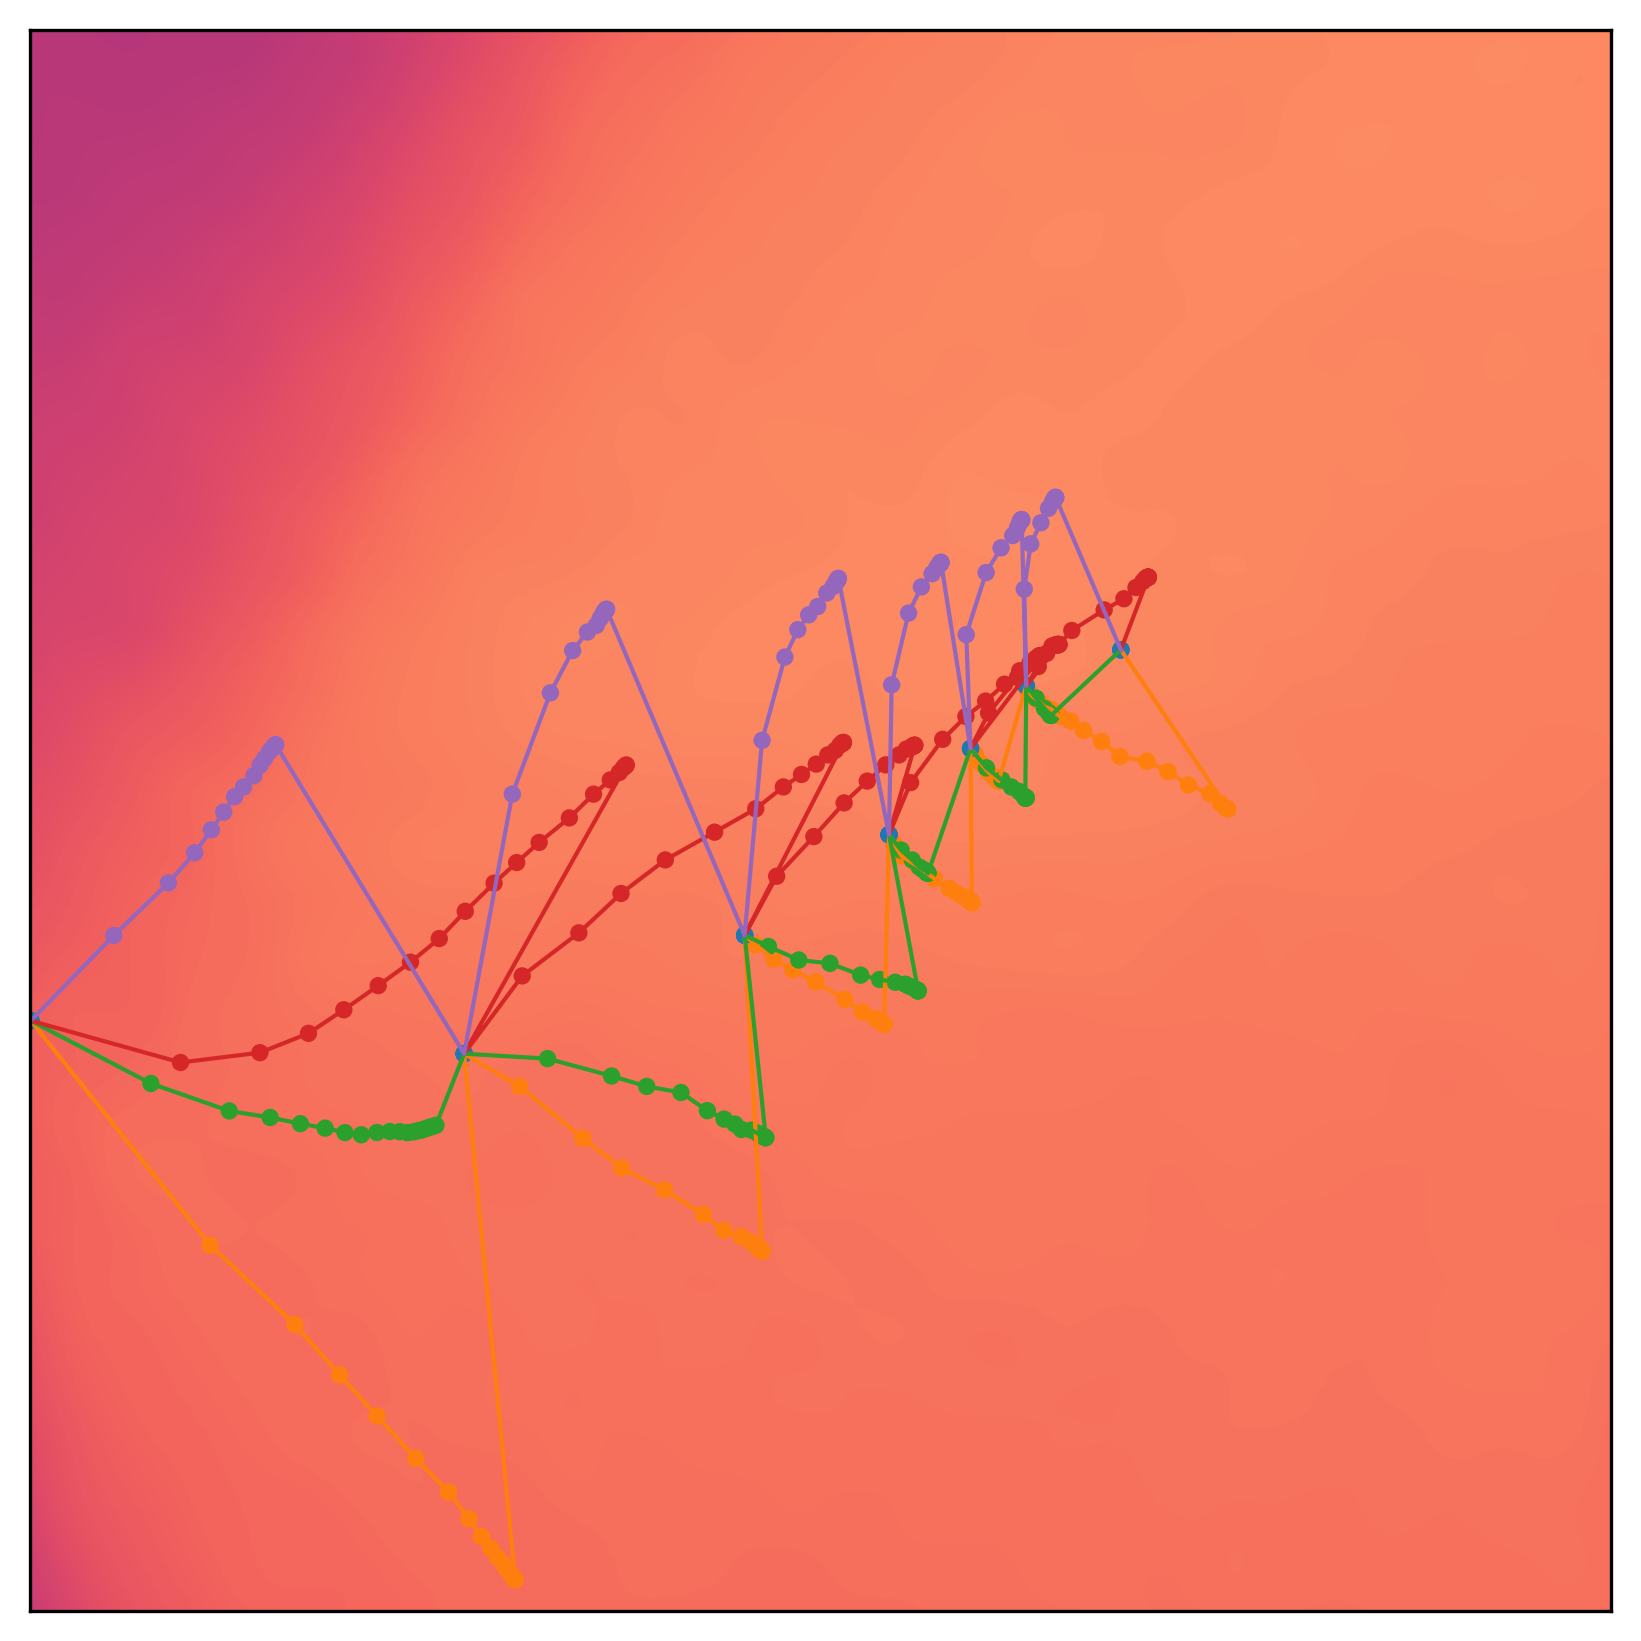

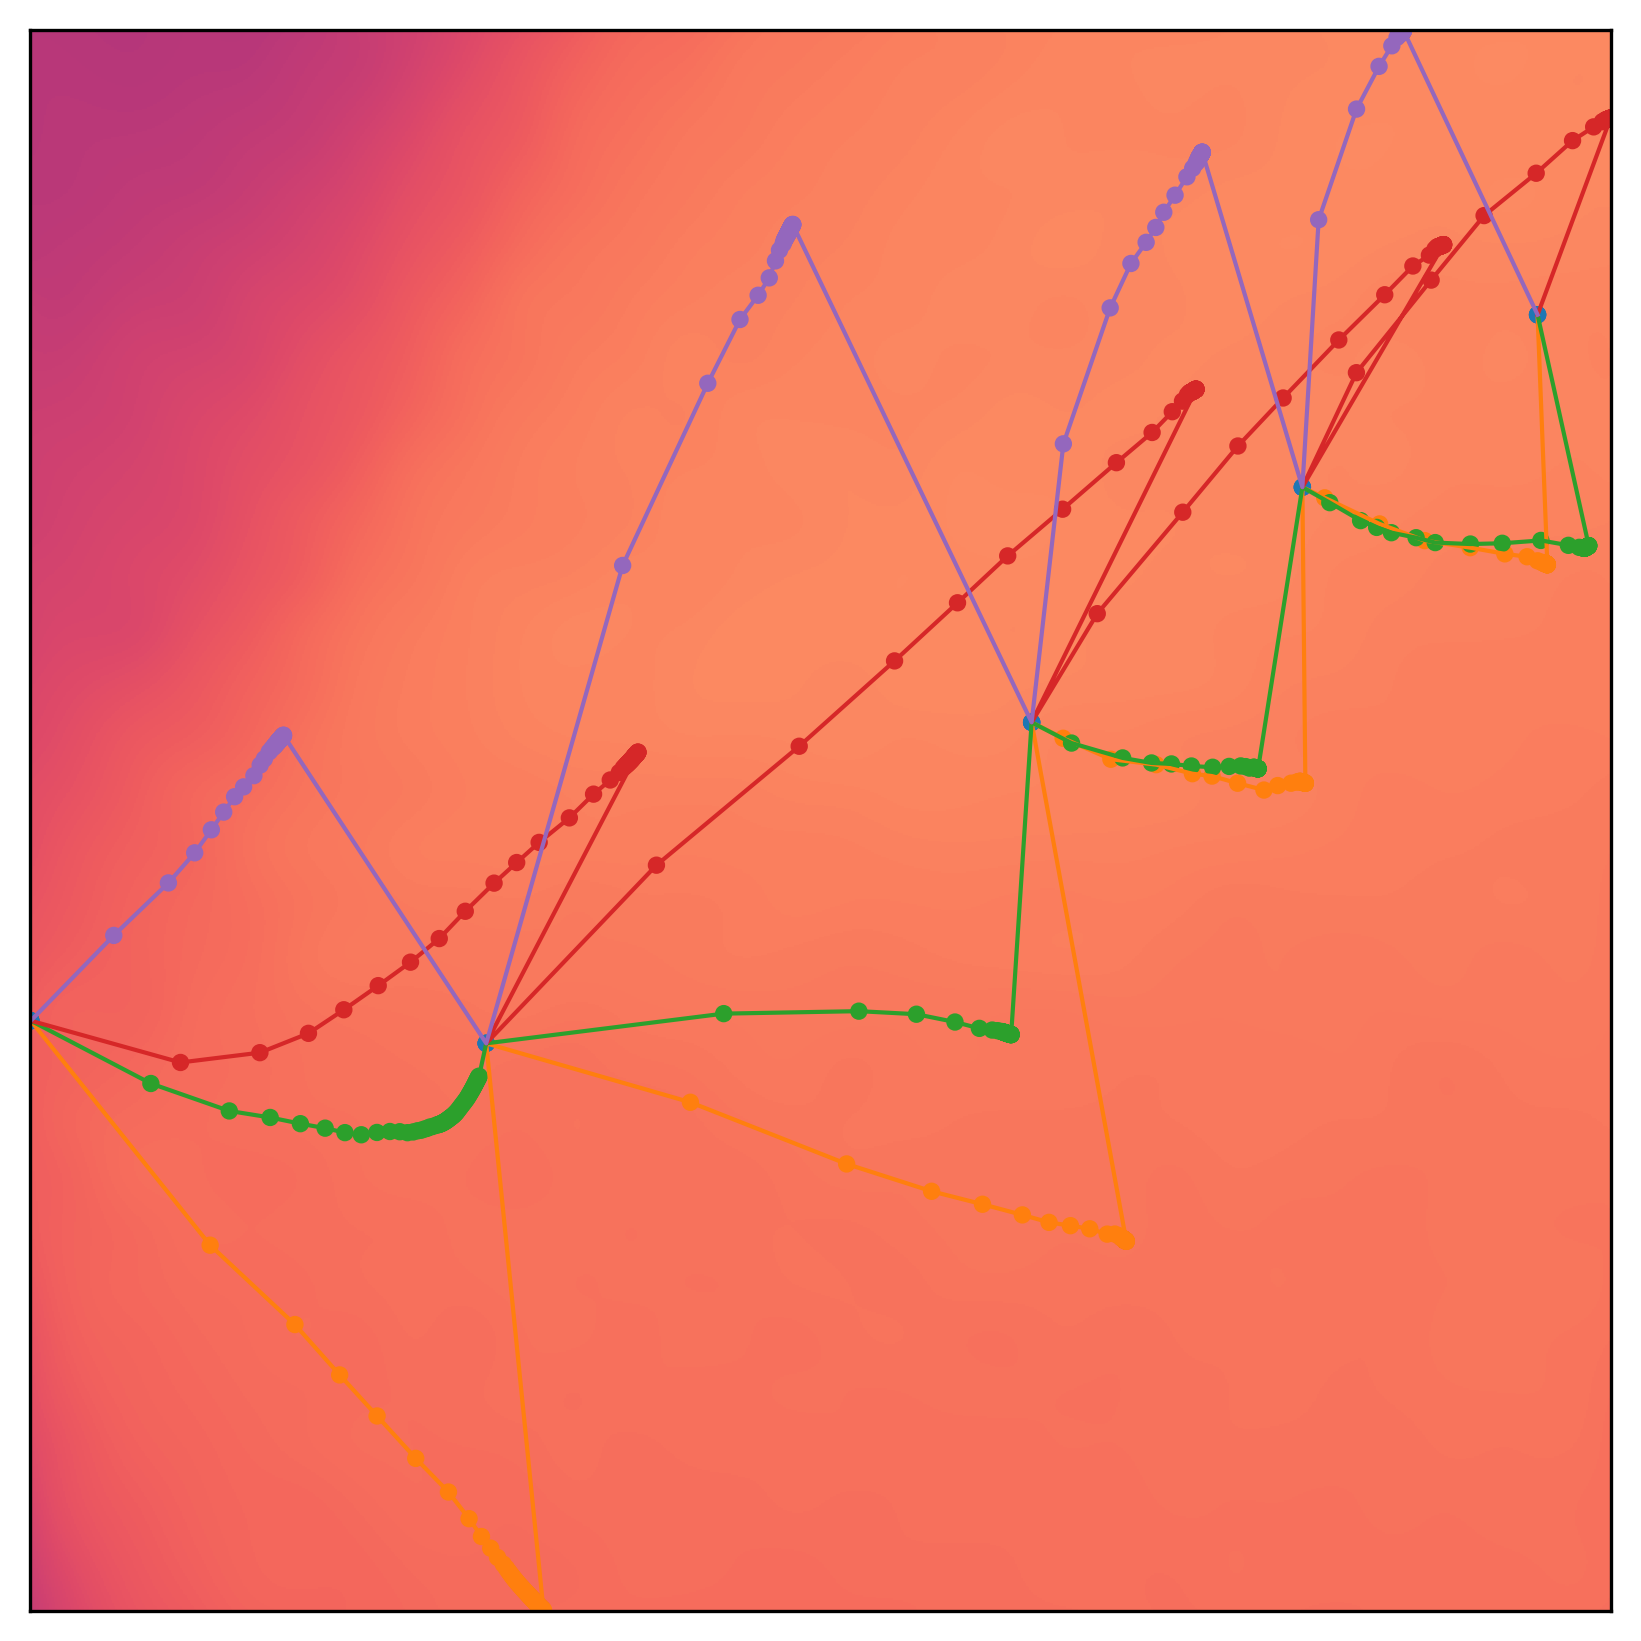

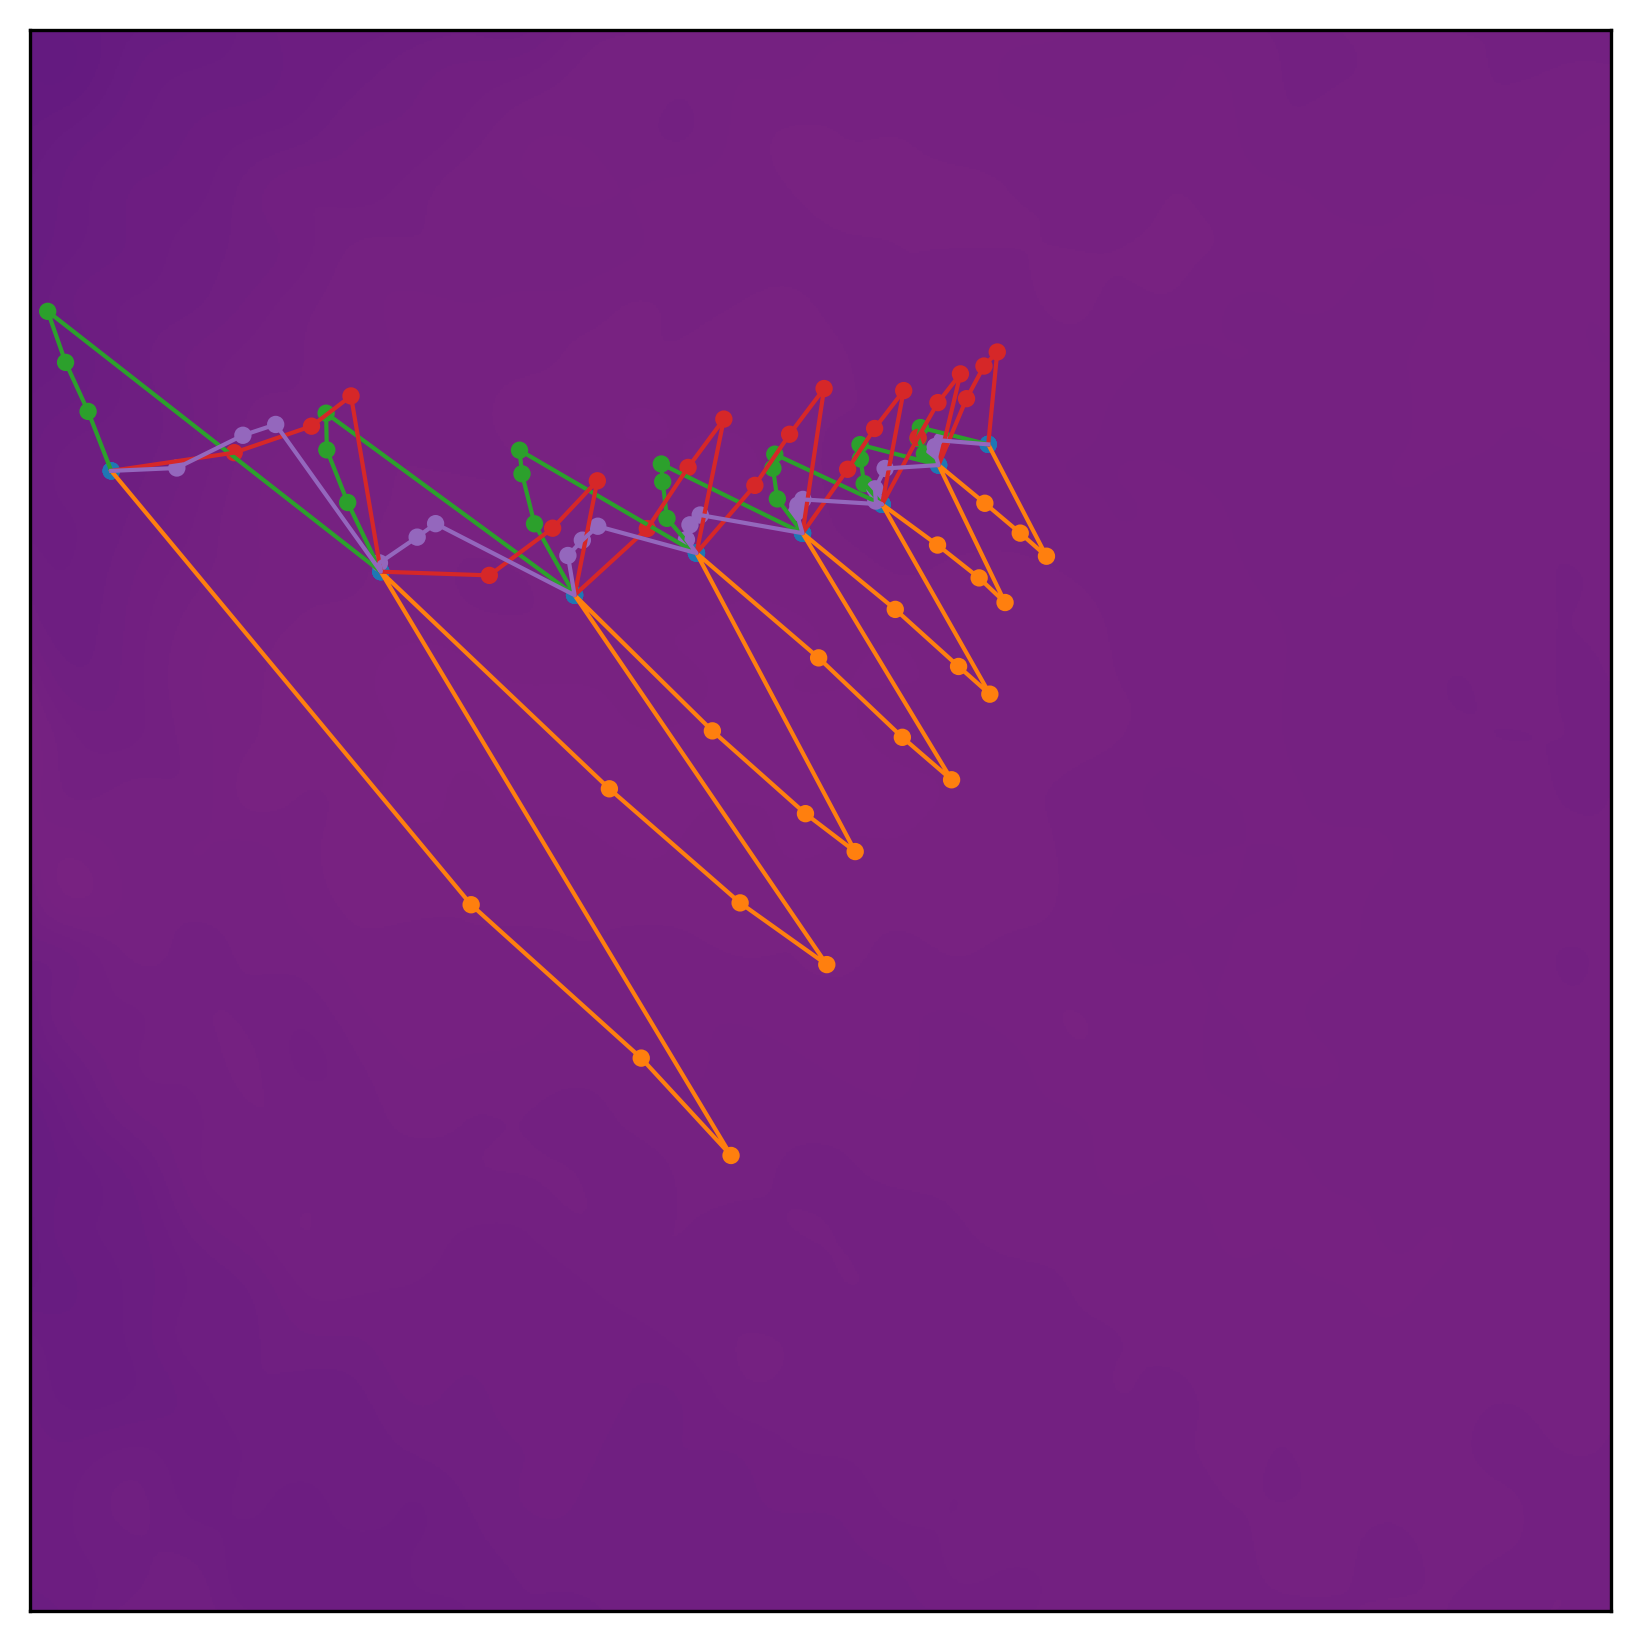

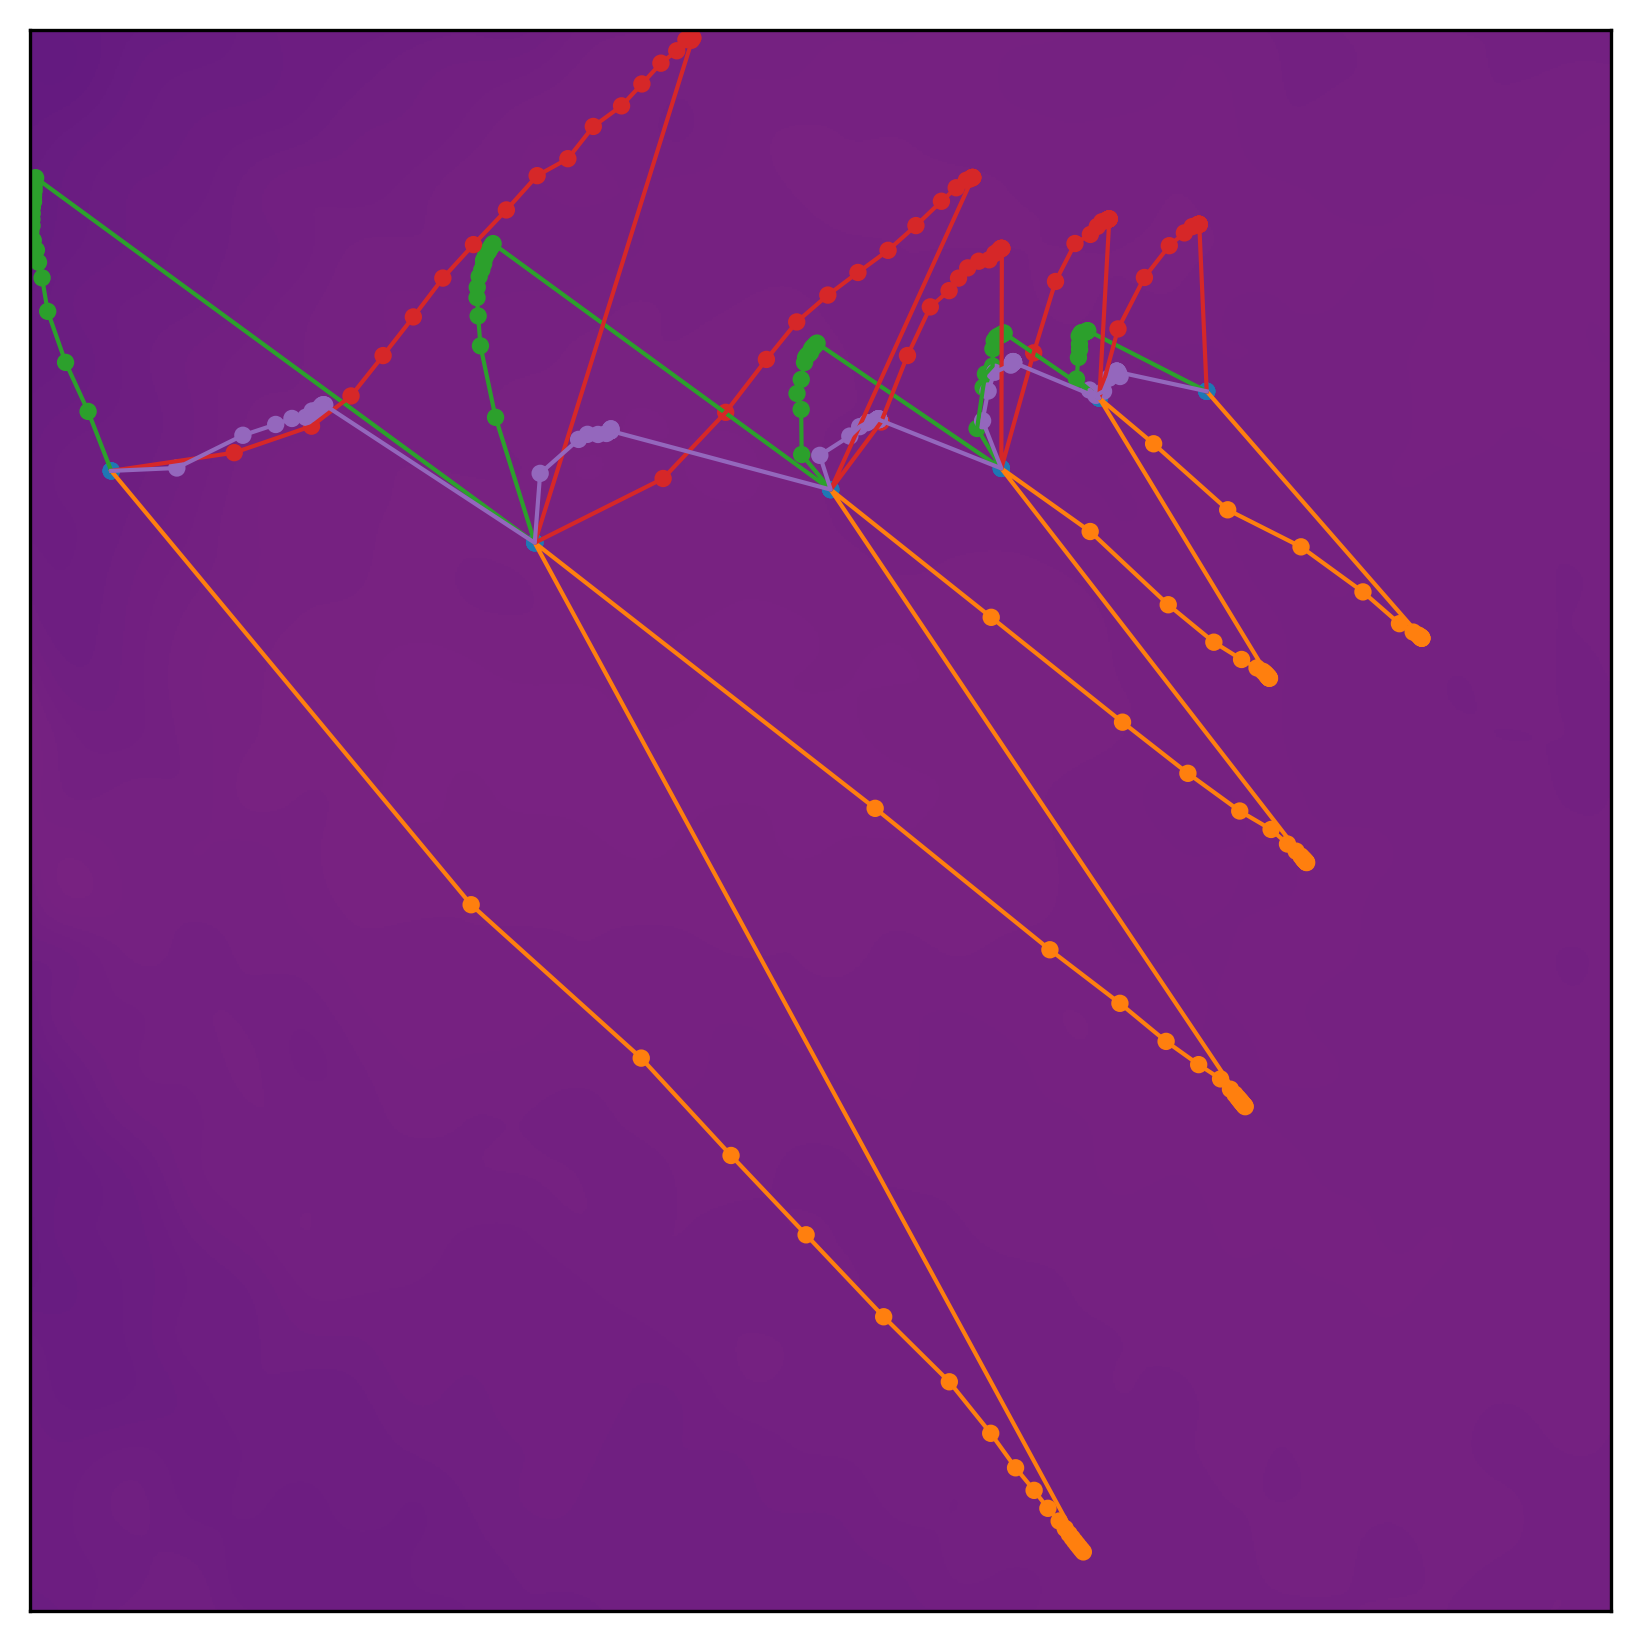

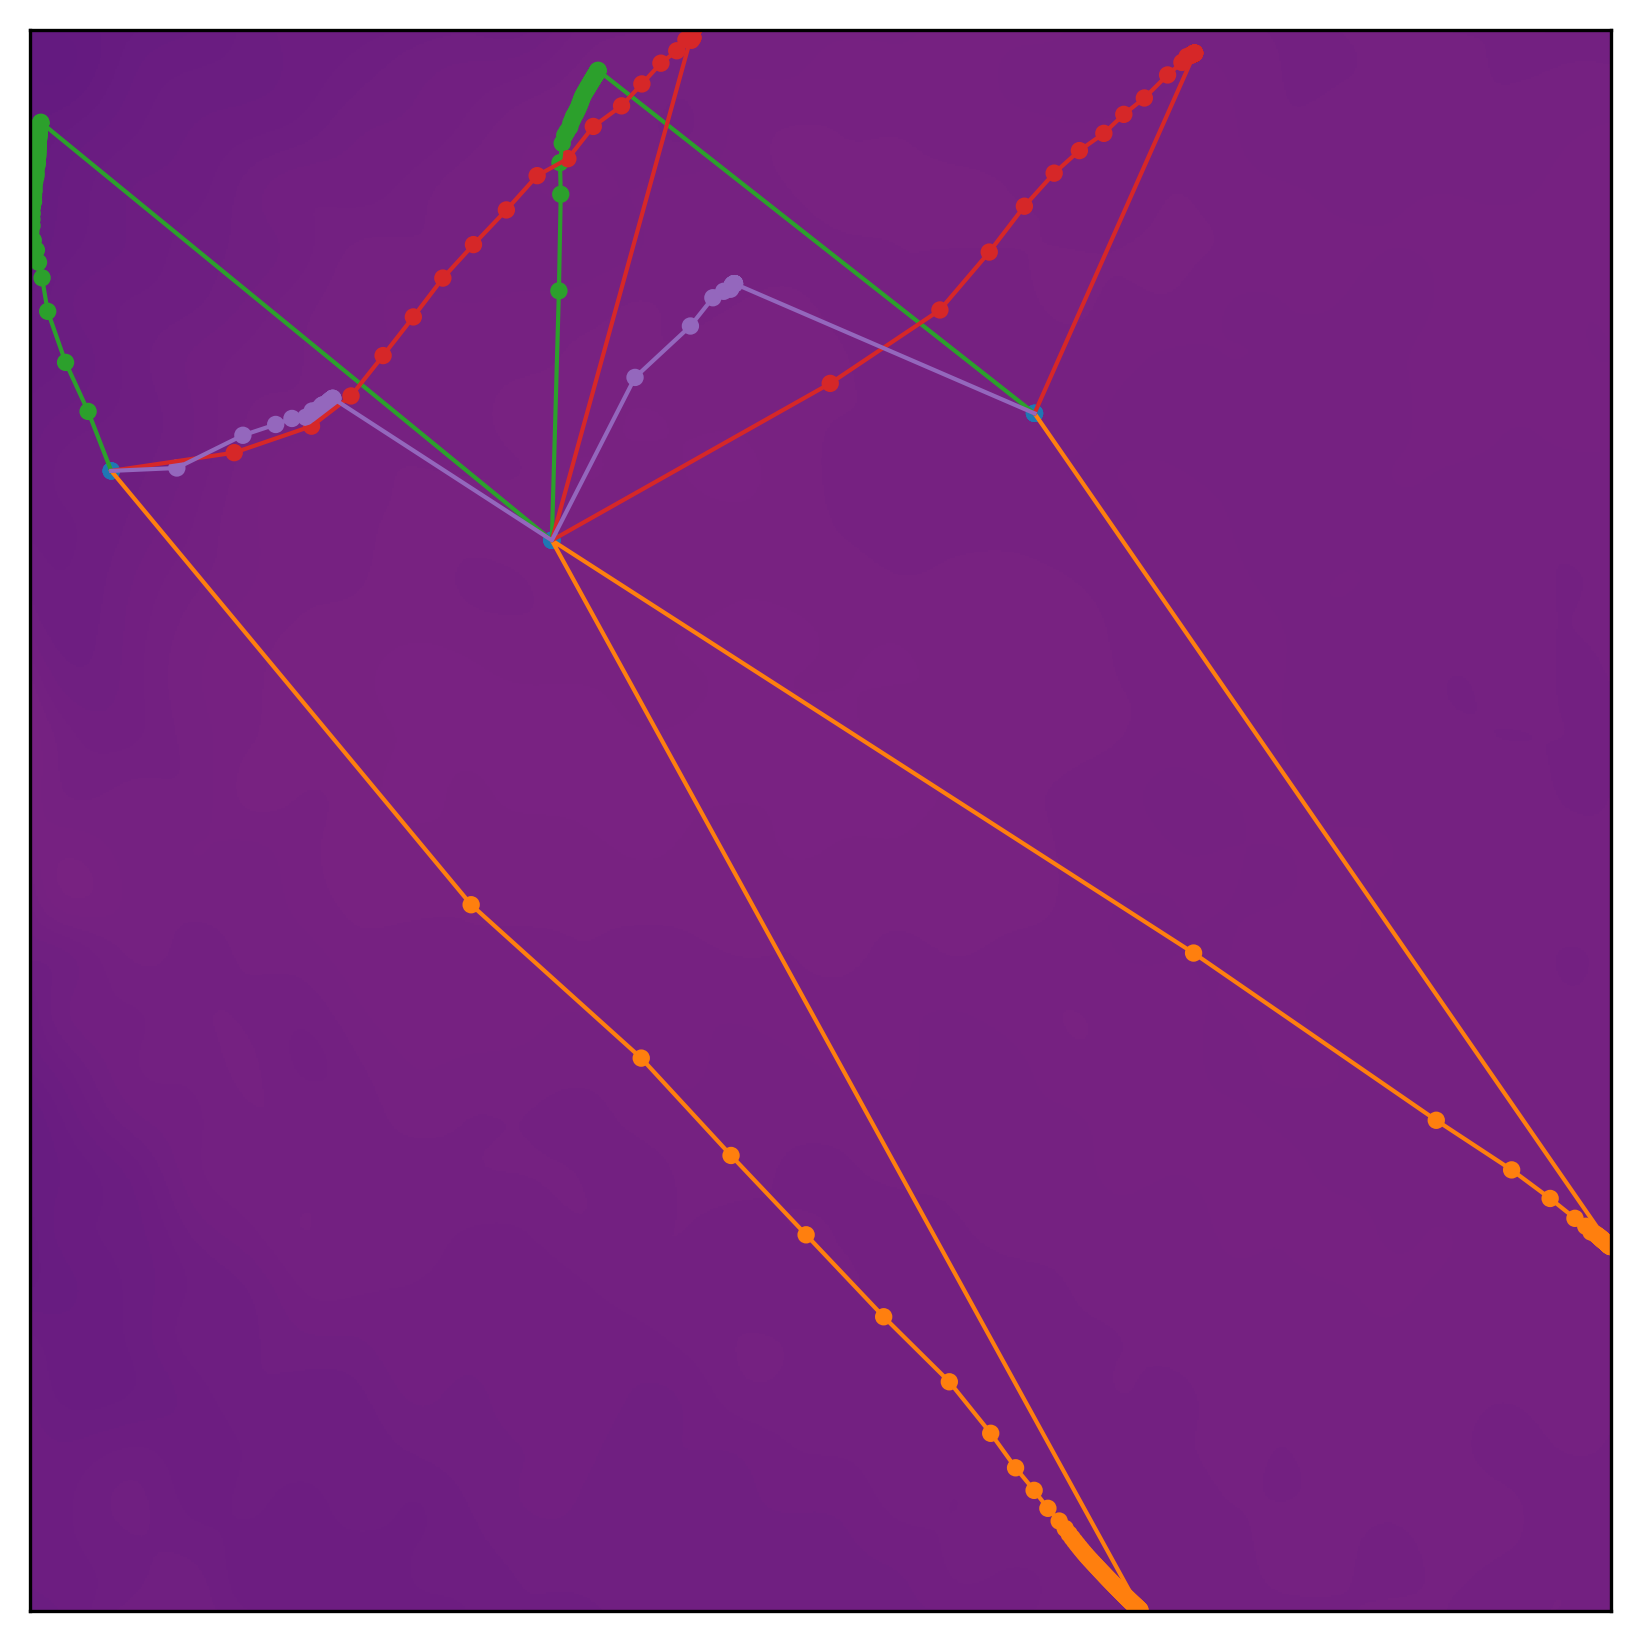

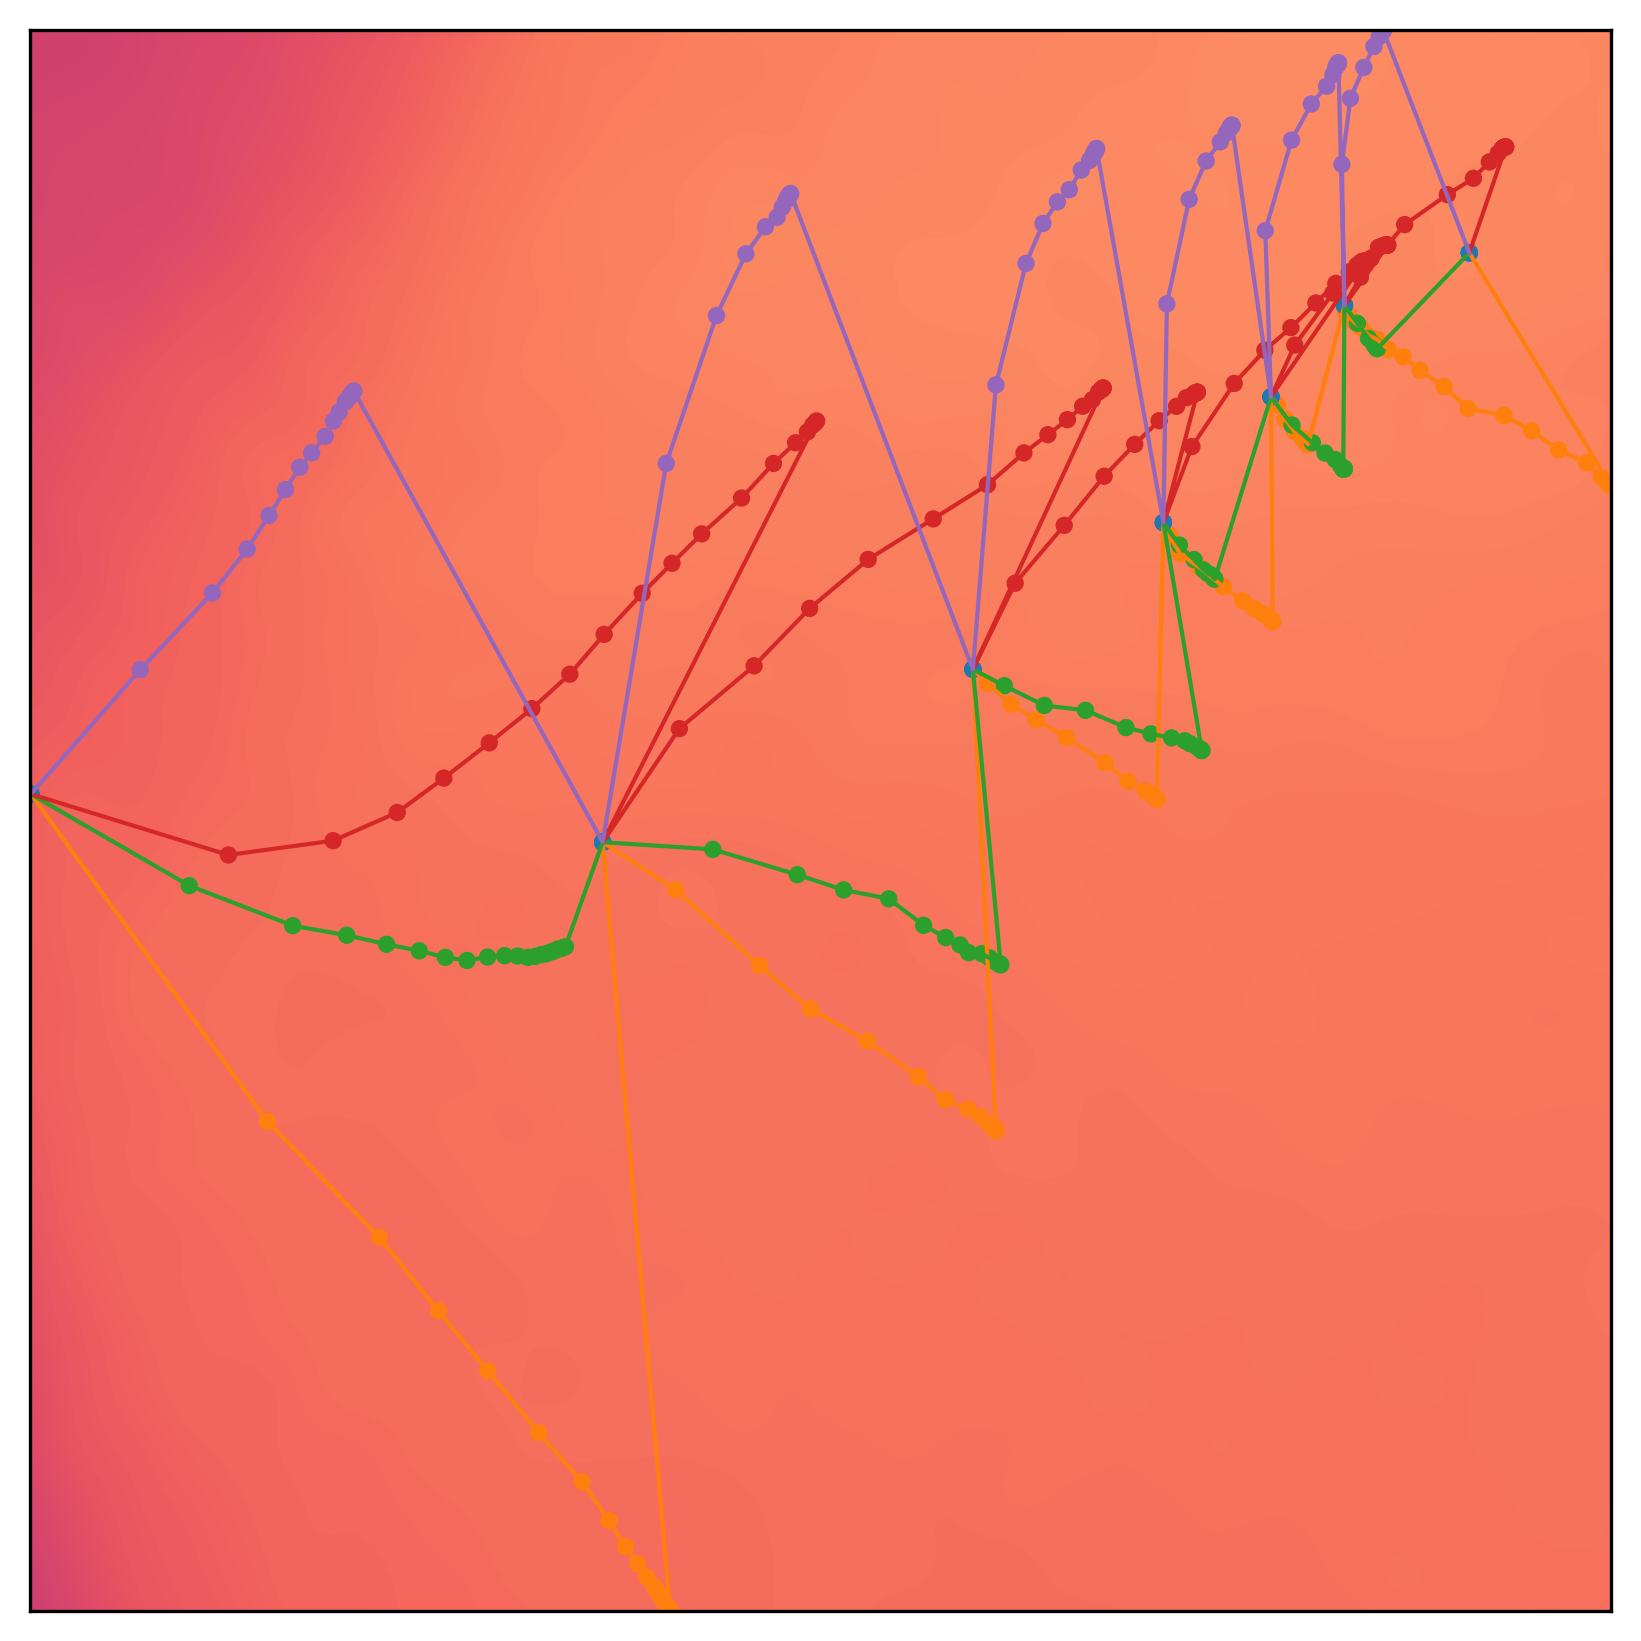

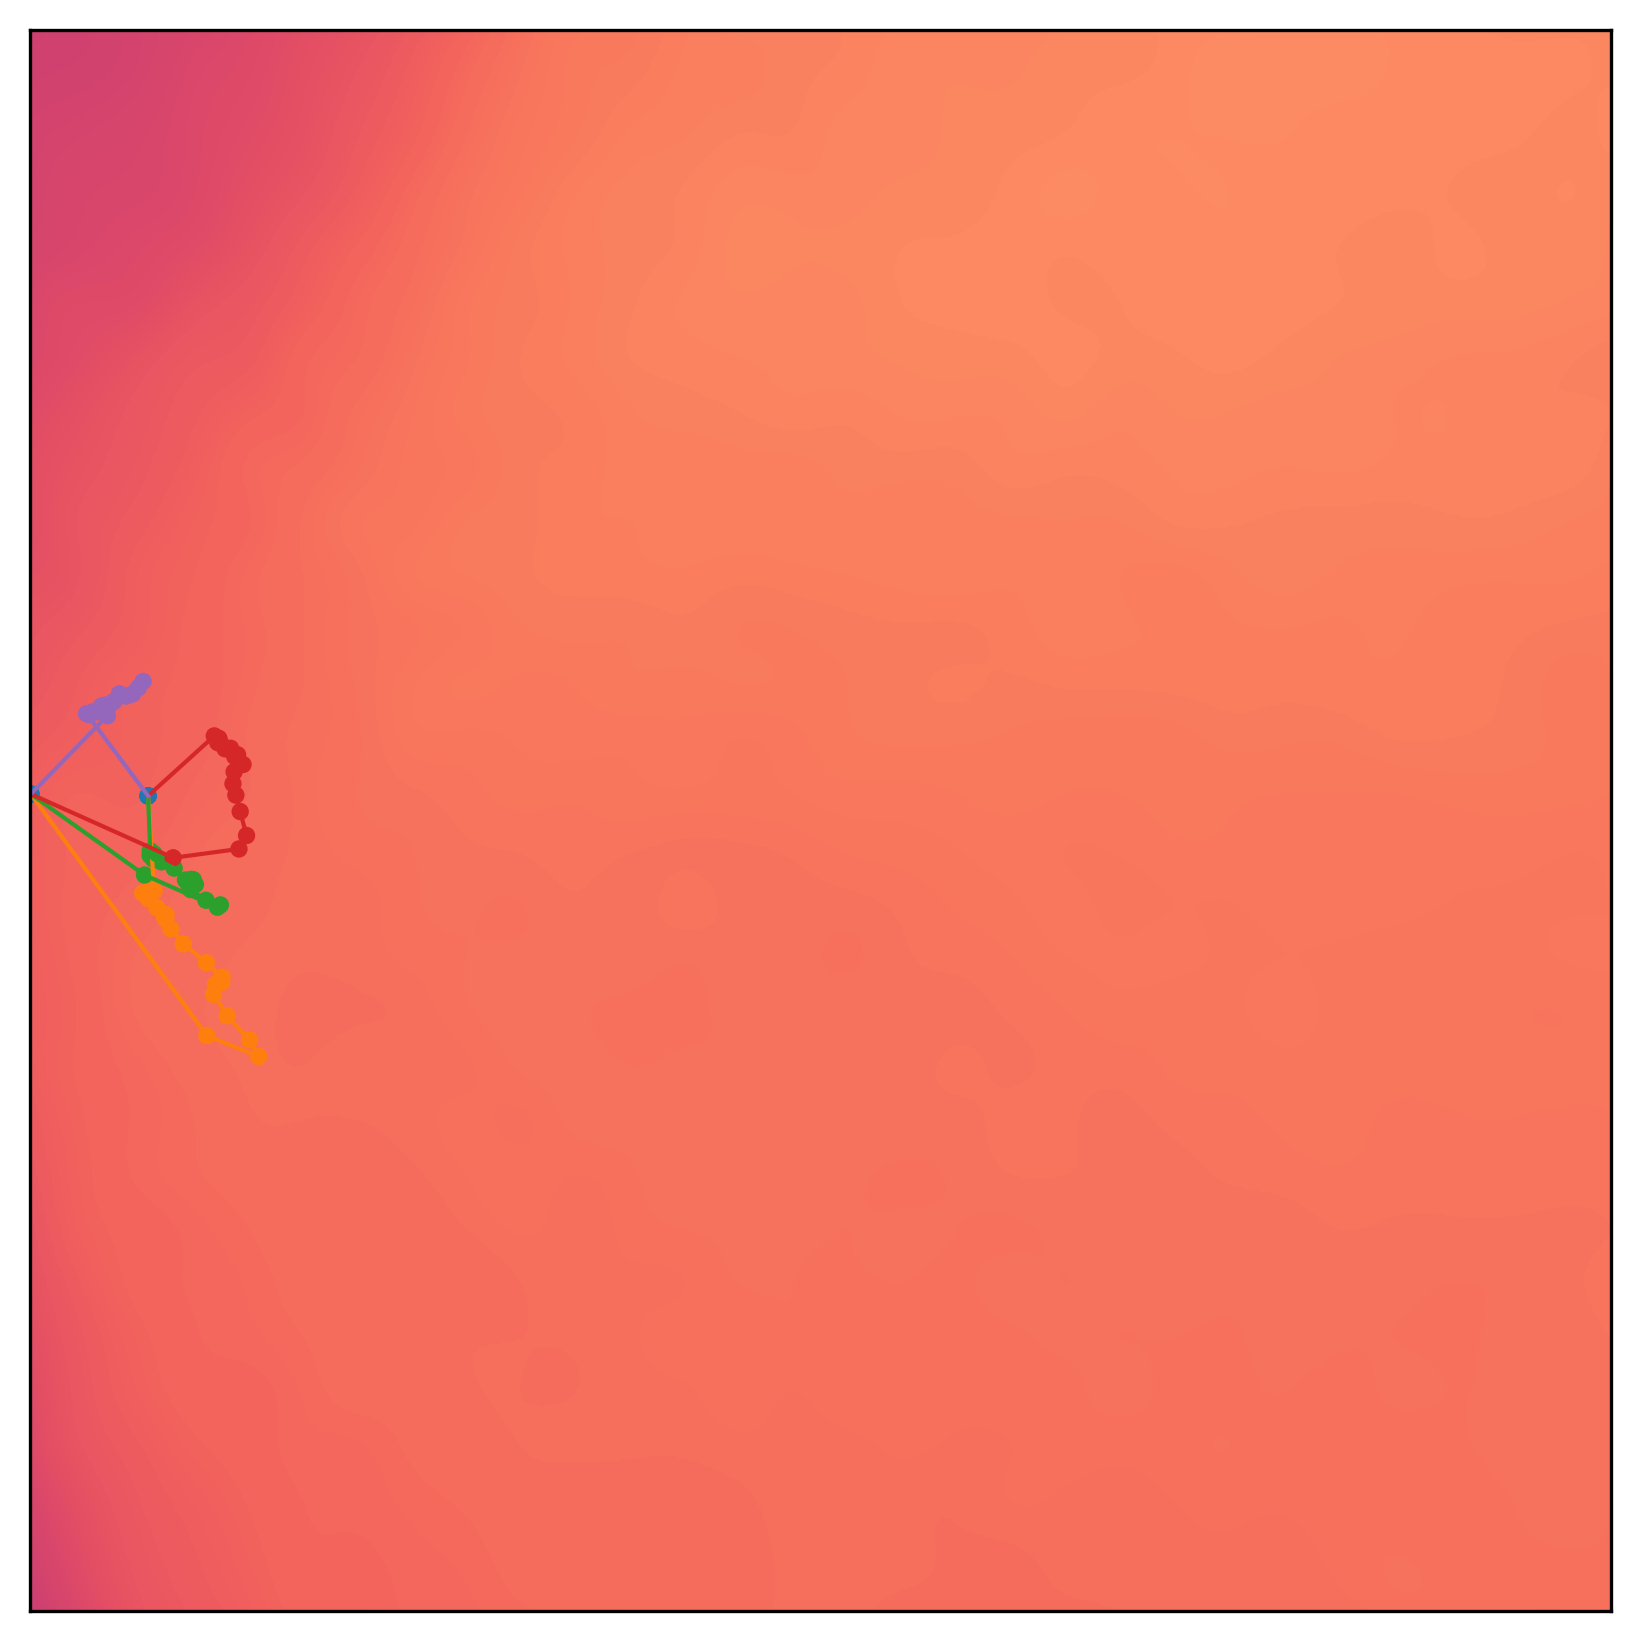

In [ ]:
# Create PCA model
b = 500
pca = IncrementalPCA(2, whiten=True, batch_size=b)
# Recreate experimental settings
for beta in tqdm([.95,0.7,.45]):
    for epochs in tqdm([4,20,80], leave=False):
        for omega in tqdm([0.,.025,.1], leave=False):
            # Load params from entire trajectory and cut the patience epochs
            fp = np.load(f"large_digits/params_beta{beta}_omega{omega}_local{epochs}.npy", mmap_mode="r")[:-5*n*epochs]
            # Fit PCA (batch-wise due to memory constraints)
            for batch in tqdm(np.array_split(fp, fp.shape[0]//b+1), leave=False):
                pca = pca.partial_fit(batch)
# Save PCA model
pickle.dump(pca, open("pca.pkl", "wb"))

# Function to reconstruct model from flat params
params, struct = jax.tree.flatten(ResNet(nnx.Rngs(42)))
shapes = [p.shape for p in params]+[None]
def reconstruct(flat_params):
    # Indices of kernels in flat vector
    slices = [slice
        (sum(map(lambda s: np.prod(s), shapes[:i])),
        sum(map(lambda s: np.prod(s), shapes[:i+1])))
    for i in range(len(shapes)-1)]
    # Get kernels as correct shape
    params = [flat_params[sl] for sl in slices]
    params = [jnp.array(p).reshape(s) for p, s in zip(params, shapes)]
    # Revert to model
    return nnx.from_tree(jax.tree.unflatten(struct, params))

# For each beta-epoch setting, plot PCA training trajectory
for beta in [.95,.7,.45]:
    # Recreate data
    *_, x_test, y_test = create_digits(beta)
    # Fix axes limits per local_epochs
    p_trans = [pca.transform(np.load(f"large_digits/params_beta{beta}_omega{0.}_local{epochs}.npy", mmap_mode="r")[:-5*n*epochs]) for epochs in [4,20,80]]
    alpha_min, beta_min = min([p[:,0].min() for p in p_trans]), min([p[:,1].min() for p in p_trans])
    alpha_max, beta_max = max([p[:,0].max() for p in p_trans]), max([p[:,1].max() for p in p_trans])
    for p_trans_, epochs in zip(p_trans, [4,20,80]):
        # Plot
        model_idx = jnp.arange(p_trans_.shape[0])%n
        pca_plot(pca, reduced_params=p_trans_, beta_min=beta_min, beta_max=beta_max, alpha_max=alpha_max, alpha_min=alpha_min, model_idx=model_idx, x=x_test, y=y_test, reconstruct=reconstruct, filename=f"large_digits/accuracy_surface/plot_beta{beta}_local{epochs}_omega{0.}.png", labels=False, epochs=epochs)

# Plot PCA for each omega setting, at fixed beta and e
*_, x_test, y_test = create_digits(.7)
# Fix axes limits per local_epochs
p_trans = [pca.transform(np.load(f"large_digits/params_beta{.7}_omega{omega}_local{20}.npy", mmap_mode="r")[:-5*n*20]) for omega in [0.,.025,.1]]
alpha_min, beta_min = min([p[:,0].min() for p in p_trans]), min([p[:,1].min() for p in p_trans])
alpha_max, beta_max = max([p[:,0].max() for p in p_trans]), max([p[:,1].max() for p in p_trans])
for p_trans_, omega in zip(p_trans, [.025,.1]):
    # Plot
    model_idx = jnp.arange(p_trans_.shape[0])%n
    pca_plot(pca, reduced_params=p_trans_, beta_min=beta_min, beta_max=beta_max, alpha_max=alpha_max, alpha_min=alpha_min, model_idx=model_idx, x=x_test, y=y_test, reconstruct=reconstruct, filename=f"large_digits/accuracy_surface/plot_beta{0.7}_local{20}_omega{omega}.png", labels=False, epochs=20)